In [1]:
from option import args
import torch
import utility
import data
import utils
import model
import loss
from trainer import Trainer
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"


number of common Subjects  171


In [2]:
ids = utils.get_ids()
ids.sort()
total_vols = args.no_vols
ids = ids[:5]
loader = data.Data(args,ids= ids,debug = True)  
checkpoint = utility.checkpoint(args)
model = model.Model(args, checkpoint)
loss = loss.Loss(args, checkpoint)

[1.2, 1.2, 1.2]
Loading Done
Making model...
Preparing loss function:
0.500 * MSE
0.500 * L1


In [3]:
model

Model(
  (model): DMRI_SR(
    (encoder): RDN(
      (SFENet1): Conv3d(7, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (SFENet2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (RDBs): ModuleList(
        (0-4): 5 x RDB(
          (convs): Sequential(
            (0): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (1): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(48, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (2): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(80, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (3): RDB_Conv(
              (co

In [4]:
for iteration, (lr_tensor, hr_tensor,pnts,scale) in enumerate(loader.testing_data, 1):
    print(lr_tensor.shape,hr_tensor.shape,pnts.shape,scale)

torch.Size([1623, 16, 16, 4, 7]) torch.Size([159, 174, 157, 5]) torch.Size([1623, 6]) [1.1 1.  1.1]
torch.Size([1423, 16, 16, 4, 7]) torch.Size([145, 208, 157, 5]) torch.Size([1423, 6]) [1.  1.2 1.1]


In [5]:
from trainer import Trainer
t = Trainer(args, loader, model, loss, checkpoint)

In [6]:
t.train()

0
stablizing


[MSE: 0.0175][L1: 0.0605][Total: 0.0780]: 100%|██████████████████████| 193/193 [00:09<00:00, 20.39it/s, scale=(1, 1, 1)]


In [7]:
lr_tensor, hr_tensor,pnts,scale = next(iter(loader.testing_data))
print(lr_tensor.shape)
lr_tensor = lr_tensor.to(t.device)
hr_tensor = hr_tensor.to(t.device)
lr_tensor = torch.permute(lr_tensor, (0,4,1,2,3))

torch.Size([1623, 16, 16, 4, 7])


In [8]:
lr_tensor.shape

torch.Size([1623, 7, 16, 16, 4])

In [9]:
with torch.no_grad():
    pred = t.model.forward(lr_tensor,scale)
pred = torch.permute(pred, (0,2,3,4,1)).float()

In [10]:
pred.shape

torch.Size([1623, 18, 16, 4, 5])

In [13]:
# %%timeit
psnr, ssim = utility.compute_psnr_ssim(hr_tensor,pred,pnts)

In [14]:
psnr,ssim

(20.466602471440783, 0.6693052747816447)

In [15]:
rec = utility.recon(pred,pnts,vol_size=hr_tensor.shape)

In [16]:
rec.shape

torch.Size([159, 174, 157, 5])

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

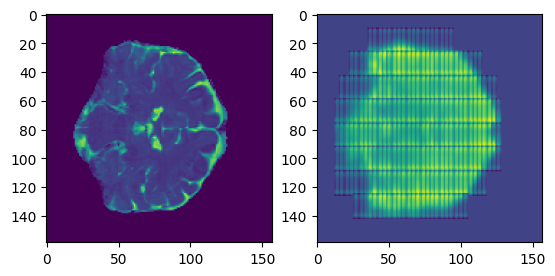

In [30]:
fig ,ax = plt.subplots(1,2)
ax[0].imshow(hr_tensor.cpu()[:,80,:,0])
ax[1].imshow(rec[:,80,:,0])
# plt.show()

In [ ]:
for i in range(5):
    t.train()

1
[Epoch 2]	Learning rate: 5.00e-5


[MSE: 0.0079][L1: 0.0344][Total: 0.0423]: 100%|████████████████| 3030/3030 [01:15<00:00, 40.35it/s, scale=[1.1 1.1 1.2]]


2


[MSE: 0.0069][L1: 0.0307][Total: 0.0376]:  86%|█████████████▋  | 2597/3030 [01:04<00:10, 40.56it/s, scale=[1.3 1.3 1.4]]